In [1]:
import sys

sys.path.append('../')

In [2]:
import torch

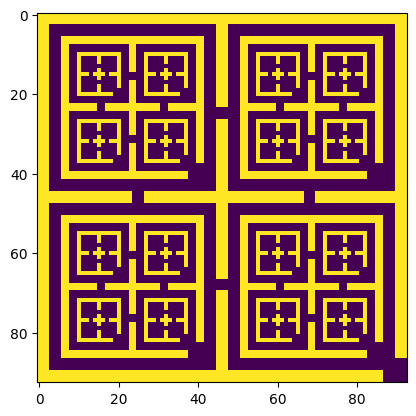

In [2]:
import numpy as np
import graphviz
from IPython.display import display
from environments.tree.tree import NaryTreeEnvironment
from environments.tree.discrete_maze import GridMazeEnvironment
from environments.tree.data import TrajectoryDataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import hypll
from hypll.manifolds.poincare_ball import Curvature, PoincareBall
from hypll.optim import RiemannianAdam
import hypll.nn as hnn
from hypll.tensors import TangentTensor, ManifoldTensor

import argparse
from environments.tree.data import TrajectoryDataset
from networks.hypnets import HyperbolicMLP, manifold_map
from networks.nets import SmallEncoder
from utils import get_maze, load_model, load_tree_model
import os
import json

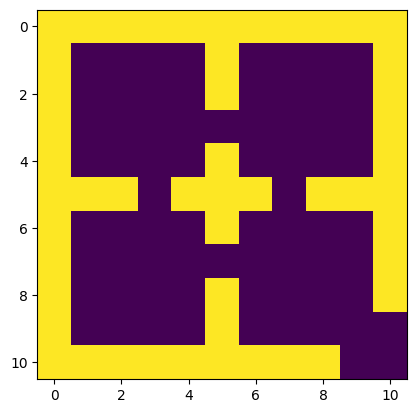

In [31]:
SetDataset

{'project': 'pyramid1', 'custom': '', 'env': 'maze', 'maze_type': 'nested_pyramid', 'hyperbolic': True, 'embedding_dim': 4, 'curvature': 1.0, 'learnable_curvature': True, 'num_epochs': 512, 'num_trajectories': 50000, 'batch_size': 512, 'num_negatives': 128, 'max_steps': 100, 'num_workers': 24, 'learning_rate': 0.01, 'depth': 7, 'branching_factor': 2, 'gamma': 0.04, 'order_name': '', 'eval_trials': 100, 'temperature': 0.1, 'architecture': 'MLP', 'symmetric': False}
loading pretrained...


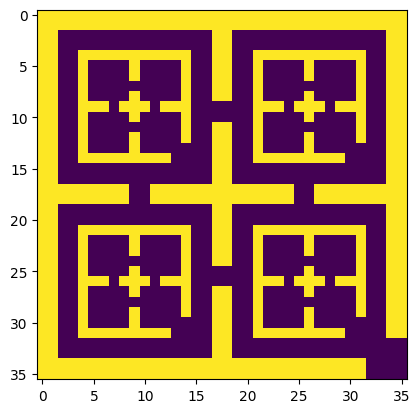

In [109]:
device = "cuda" if torch.cuda.is_available() else "cpu"
saved = '/home/yongweic/hyperbolic/saved_models/env_maze_experiment_hyperbolic_True_symmetric_False_curvature_1.0_learnable_True_epochs_512_trajectories_50000_depth_7_branch_2_embeddingdim_4_gamma_0.04_batch_512'
# saved = '/home/yongweic/hyperbolic/saved_models/env_maze_experiment__maze_type_pyramid_hyperbolic_True_symmetric_False_curvature_1.0_learnable_True_epochs_512_trajectories_50000_depth_7_branch_2_embeddingdim_2_gamma_0.04_batch_512'

config = json.load(open(os.path.join(saved, 'config.json')))
print(config)

branching_factor = config['branching_factor']
depth = config['depth']


maze = get_maze(config['maze_type'])
env = GridMazeEnvironment(maze=maze)
hyperbolic = config['hyperbolic']
model_dict = load_tree_model(config, 
                             env.num_states, 
                             5,  
                             device, 
                             pretrained_path=saved, 
                             epoch=96)

encoder1 = model_dict['encoder1']
encoder2 = model_dict['encoder2']
manifold = model_dict['manifold']

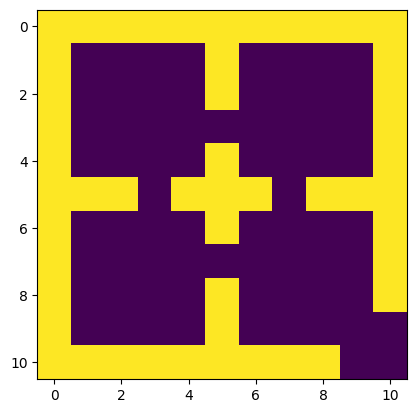

In [74]:
plt.imshow(maze)

0 1
1 3
3 7
7 15
15 31
31 63
63 127


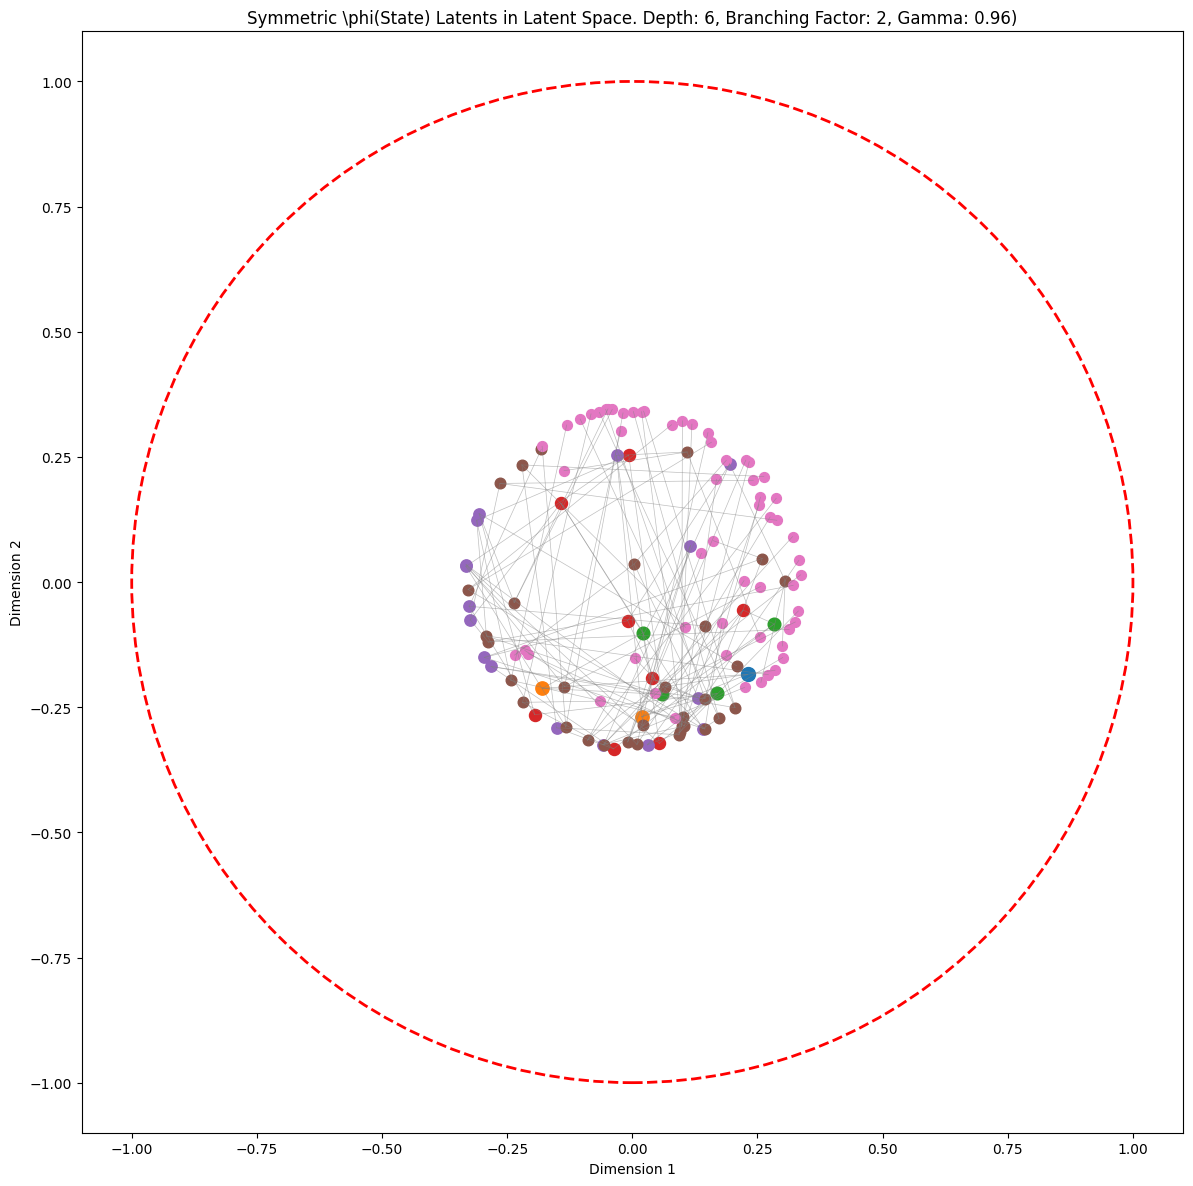

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import torch

if config['embedding_dim'] == 2:
    with torch.no_grad():
        nodes = torch.arange(env.num_states)[:, None]
        latents = encoder2(nodes)
        if hyperbolic:
            latents = latents.tensor


    max_depth = int(np.log(env.num_states) / np.log(branching_factor))
    sizes = np.linspace(100, 50, max_depth + 1)  # Decreasing sizes from 100 to 50

    plt.figure(figsize=(12, 12))  # Make it square

    if hyperbolic:
        # Plot the unit circle
        circle = plt.Circle((0, 0), 1, fill=False, color='r', linestyle='--', linewidth=2)
        plt.gca().add_artist(circle)

    # Plot lines connecting parents to children
    for node in range(1, env.num_states):  # Start from 1 to skip the root
        parent = (node - 1) // branching_factor
        plt.plot([latents[parent, 0], latents[node, 0]], 
                 [latents[parent, 1], latents[node, 1]], 
                 color='gray', alpha=0.5, linewidth=0.5)


    # Plot nodes
    l = 0
    for i in range(max_depth + 1):
        r = l + branching_factor**i
        print(l, r)
        plt.scatter(latents[l:r, 0], latents[l:r, 1], s=sizes[i])
        l = r

    plt.title(f"Symmetric \phi(State) Latents in Latent Space. Depth: {max_depth}, Branching Factor: {branching_factor}, Gamma: {1 - config['gamma']})")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.axis('equal')  # This ensures the circle is circular and not elliptical
    if hyperbolic:
        plt.xlim(-1.1, 1.1)
        plt.ylim(-1.1, 1.1)
    plt.gca().set_aspect('equal', adjustable='box')  # This ensures the aspect ratio stays constant
    plt.tight_layout()
    plt.show()

In [76]:
import torch
import geoopt

def compute_geodesic_points(x, y, c, num_points=100):
    """
    Compute points along the geodesic between two points in a Poincaré ball.

    Parameters:
    x (array-like): Starting point coordinates
    y (array-like): Ending point coordinates
    num_points (int): Number of points to compute along the geodesic

    Returns:
    torch.Tensor: Tensor of shape (num_points, n_dims) containing the geodesic points
    """
    # Create PoincareBall manifold
    manifold = geoopt.PoincareBall(c=c)
    
    # Convert points to tensors
    x_tensor = geoopt.ManifoldTensor(torch.tensor(x, dtype=torch.float64), manifold=manifold)
    y_tensor = geoopt.ManifoldTensor(torch.tensor(y, dtype=torch.float64), manifold=manifold)
    
    # Ensure inputs are 2D
    if x_tensor.dim() == 1:
        x_tensor = x_tensor.unsqueeze(0)
    if y_tensor.dim() == 1:
        y_tensor = y_tensor.unsqueeze(0)
    
    # Compute geodesic
    t_values = torch.linspace(0, 1, num_points)
    geodesic_points = manifold.geodesic(t_values.unsqueeze(-1), x_tensor, y_tensor)
    
    return geodesic_points.squeeze(1)  # Remove batch dimension if present

# Example usage:
x = [0.3, 0.2, 0.1]
y = [-0.4, 0.5, -0.3]
geodesic_points = compute_geodesic_points(x, y, float(manifold.c.value))

print(f"Geodesic points shape: {geodesic_points.shape}")
print("First few points:")
print(geodesic_points[:5])

Geodesic points shape: torch.Size([100, 3])
First few points:
tensor([[0.3000, 0.2000, 0.1000],
        [0.3004, 0.2003, 0.1001],
        [0.3009, 0.2006, 0.1003],
        [0.3014, 0.2010, 0.1005],
        [0.3019, 0.2013, 0.1006]], dtype=torch.float64)


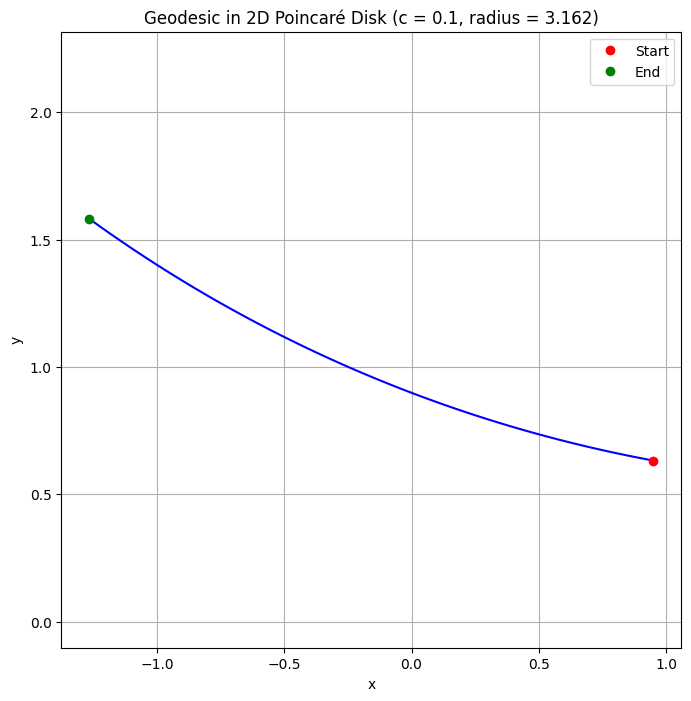

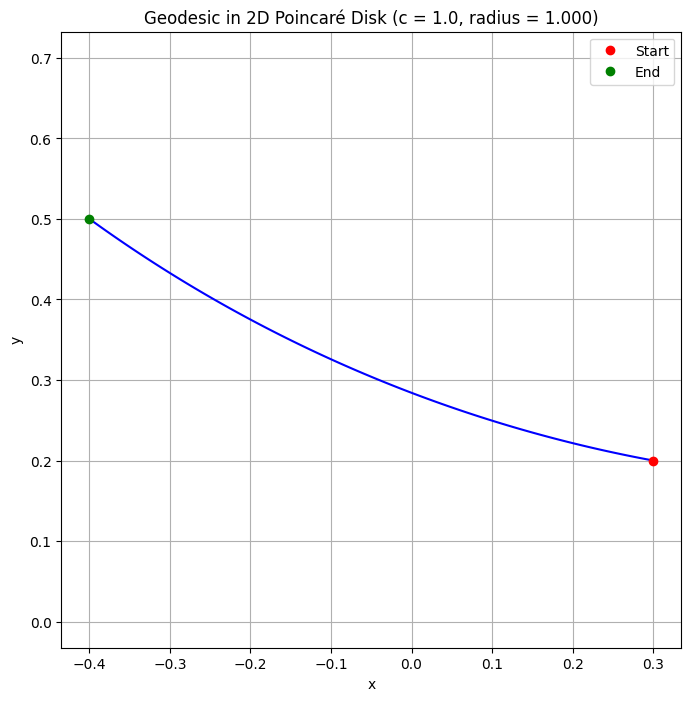

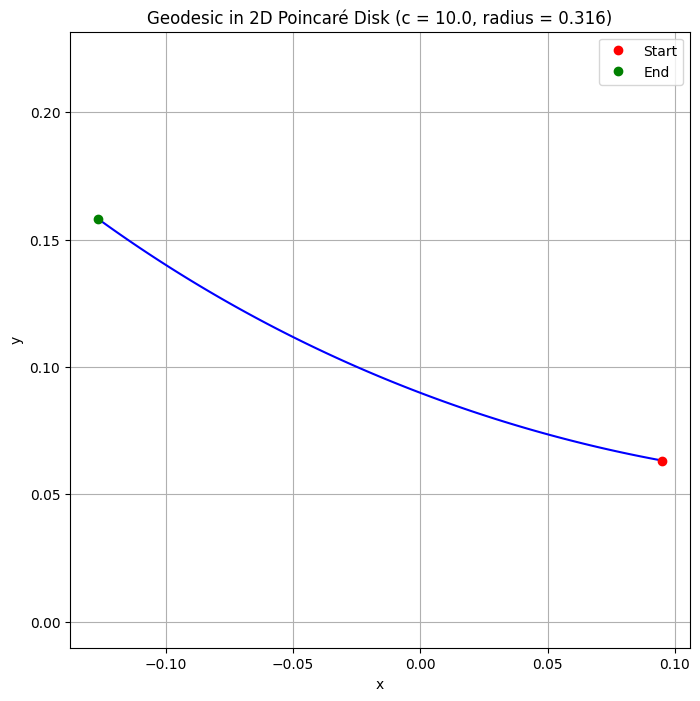

In [77]:
import torch
import geoopt
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

def compute_geodesic_points(x, y, num_points=100, c=1.0):
    """
    Compute points along the geodesic between two points in a Poincaré ball.
    """
    manifold = geoopt.PoincareBall(c=c)
    
    x_tensor = geoopt.ManifoldTensor(torch.tensor(x, dtype=torch.float64), manifold=manifold)
    y_tensor = geoopt.ManifoldTensor(torch.tensor(y, dtype=torch.float64), manifold=manifold)
    
    if x_tensor.dim() == 1:
        x_tensor = x_tensor.unsqueeze(0)
    if y_tensor.dim() == 1:
        y_tensor = y_tensor.unsqueeze(0)
    
    t_values = torch.linspace(0, 1, num_points)
    geodesic_points = manifold.geodesic(t_values.unsqueeze(-1), x_tensor, y_tensor)
    
    return geodesic_points.squeeze(1)

def plot_geodesic_2d(x, y, num_points=100, c=1.0):
    radius = 1 / np.sqrt(c)
    geodesic_points = compute_geodesic_points(x, y, num_points, c).numpy()
    
    plt.figure(figsize=(8, 8))
    circle = plt.Circle((0, 0), radius, fill=False)
    plt.gca().add_artist(circle)
    plt.plot(geodesic_points[:, 0], geodesic_points[:, 1], 'b-')
    plt.plot(x[0], x[1], 'ro', label='Start')
    plt.plot(y[0], y[1], 'go', label='End')
    plt.xlim(-1.5*radius, 1.5*radius)
    plt.ylim(-1.5*radius, 1.5*radius)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Geodesic in 2D Poincaré Disk (c = {c}, radius = {radius:.3f})')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

def plot_geodesic_3d(x, y, num_points=100, c=1.0):
    radius = 1 / np.sqrt(c)
    geodesic_points = compute_geodesic_points(x, y, num_points, c).numpy()
    
    fig = go.Figure()

    fig.add_trace(go.Scatter3d(x=geodesic_points[:, 0], y=geodesic_points[:, 1], z=geodesic_points[:, 2],
                               mode='lines', name='Geodesic'))

    fig.add_trace(go.Scatter3d(x=[x[0]], y=[x[1]], z=[x[2]], mode='markers', marker=dict(size=5, color='red'), name='Start'))
    fig.add_trace(go.Scatter3d(x=[y[0]], y=[y[1]], z=[y[2]], mode='markers', marker=dict(size=5, color='green'), name='End'))

    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    sphere_x = radius * np.cos(u)*np.sin(v)
    sphere_y = radius * np.sin(u)*np.sin(v)
    sphere_z = radius * np.cos(v)
    fig.add_trace(go.Surface(x=sphere_x, y=sphere_y, z=sphere_z, opacity=0.1, showscale=False))

    fig.update_layout(title=f'Geodesic in 3D Poincaré Ball (c = {c}, radius = {radius:.3f})',
                      scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
                                 aspectmode='cube', aspectratio=dict(x=1, y=1, z=1)),
                      width=800, height=800)

    fig.show()

# Example usage with different curvatures
x_2d = [0.3, 0.2]
y_2d = [-0.4, 0.5]

for c in [0.1, 1.0, 10.0]:
    # Scale the points according to the radius of the Poincaré disk
    radius = 1 / np.sqrt(c)
    x_2d_scaled = [x * radius for x in x_2d]
    y_2d_scaled = [y * radius for y in y_2d]
    plot_geodesic_2d(x_2d_scaled, y_2d_scaled, c=c)

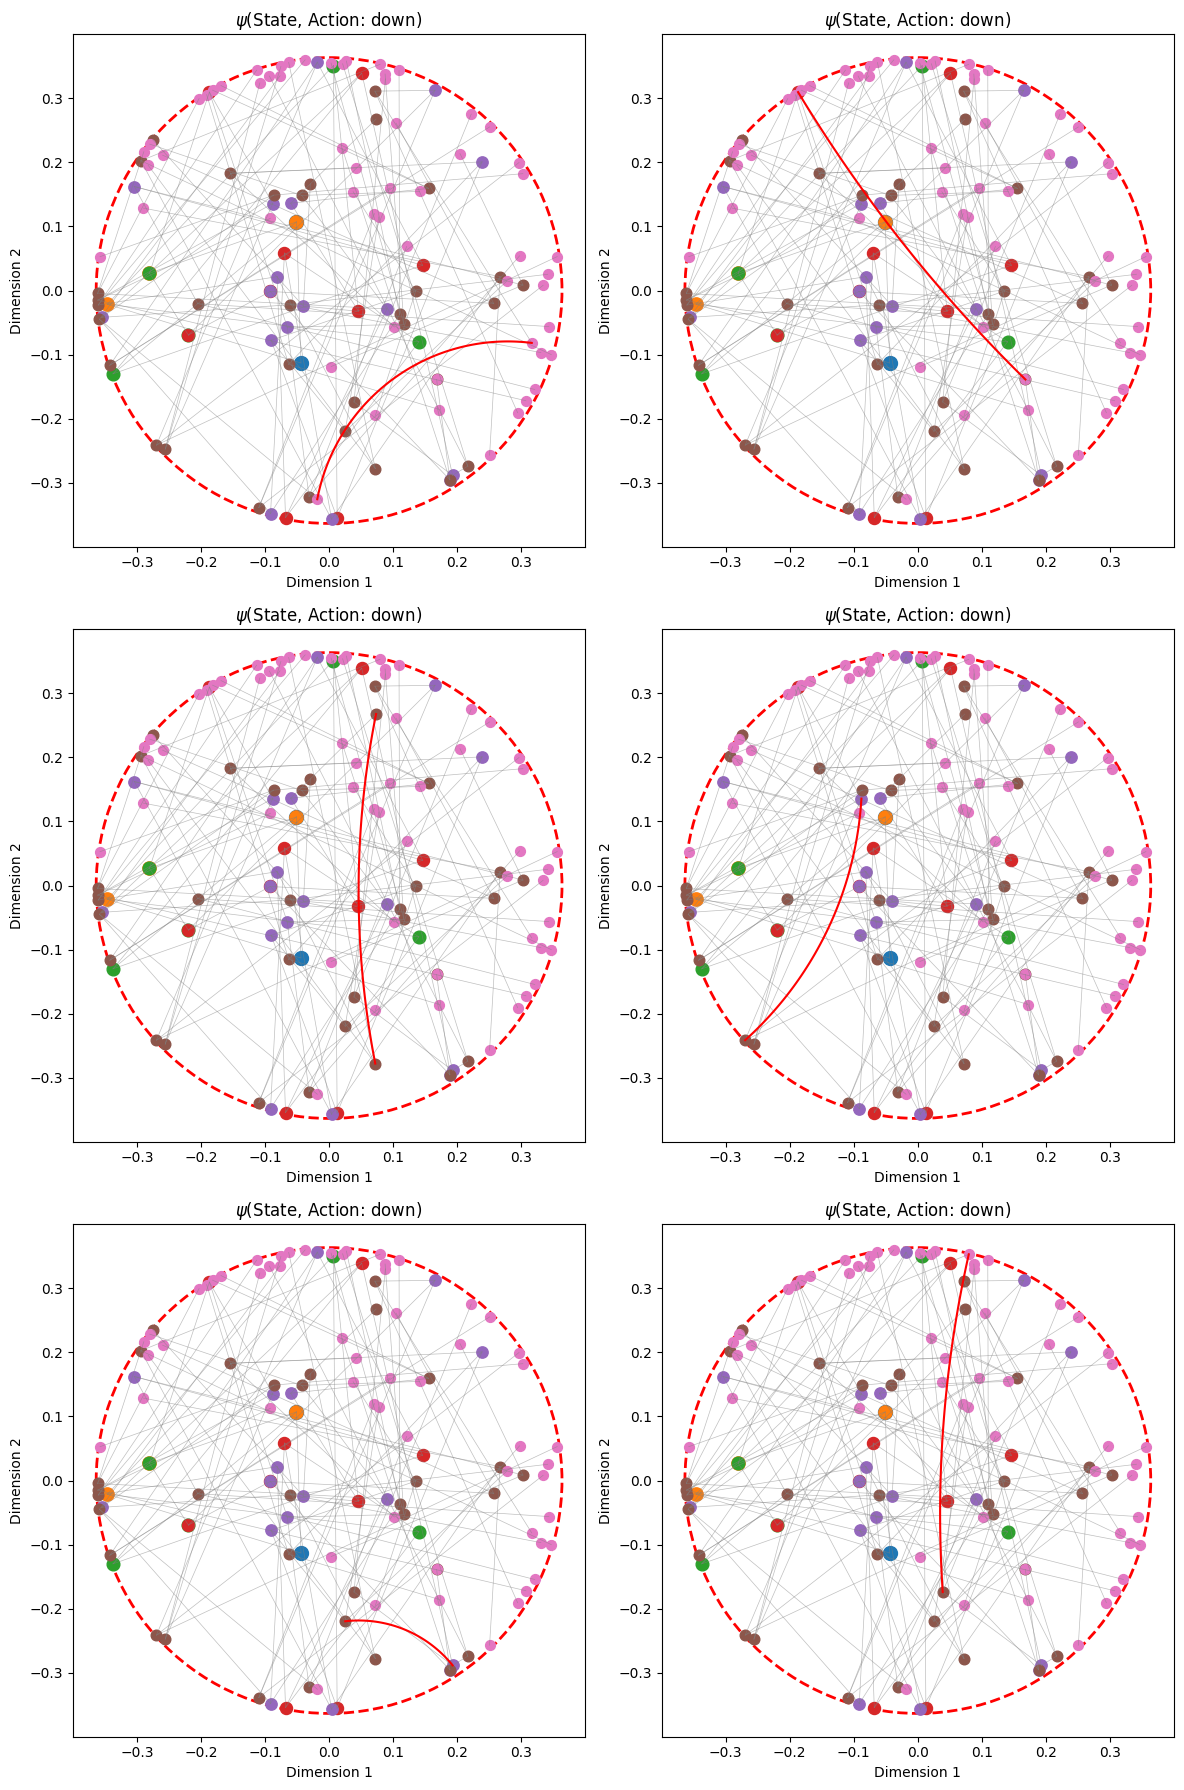

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import geoopt


def compute_geodesic_points(x, y, num_points=100, c=1.0):
    """
    Compute points along the geodesic between two points in a Poincaré ball.
    """
    manifold = geoopt.PoincareBall(c=c)
    
    x_tensor = geoopt.ManifoldTensor(torch.tensor(x, dtype=torch.float64), manifold=manifold)
    y_tensor = geoopt.ManifoldTensor(torch.tensor(y, dtype=torch.float64), manifold=manifold)
    
    if x_tensor.dim() == 1:
        x_tensor = x_tensor.unsqueeze(0)
    if y_tensor.dim() == 1:
        y_tensor = y_tensor.unsqueeze(0)
    
    t_values = torch.linspace(0, 1, num_points)
    geodesic_points = manifold.geodesic(t_values.unsqueeze(-1), x_tensor, y_tensor)
    
    return geodesic_points.squeeze(1)

def plot_latents(ax, latents, title='', g_points=None, c=1.0):
    radius = 1 / np.sqrt(c)
    if hyperbolic:
        circle = plt.Circle((0, 0), radius, fill=False, color='r', linestyle='--', linewidth=2)
        ax.add_artist(circle)
    for node in range(1, env.num_states):
        parent = (node - 1) // branching_factor
        ax.plot([latents[parent, 0], latents[node, 0]], 
                [latents[parent, 1], latents[node, 1]], 
                color='gray', alpha=0.5, linewidth=0.5)
    for i in range(max_depth + 1):
        l = branching_factor**i - 1
        r = min(branching_factor**(i + 1), env.num_states)
        ax.scatter(latents[l:r, 0], latents[l:r, 1], s=sizes[i])
        
    if g_points is not None:
        p1, p2 = g_points
        geodesic_points = compute_geodesic_points(p1, p2, num_points=100, c=c).numpy()
        # Plot the geodesic
        ax.plot(geodesic_points[:, 0], geodesic_points[:, 1], 'r-')
    ax.set_title(title)
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.axis('equal')
    if hyperbolic:
        ax.set_xlim(-1.1*radius, 1.1*radius)
        ax.set_ylim(-1.1*radius, 1.1*radius)
    ax.set_aspect('equal', adjustable='box')

fig, axes = plt.subplots(3, 2, figsize=(12, 18))
axes = axes.flatten()
a = 3
c = float(manifold.c.value)

if config['embedding_dim'] == 2:
    with torch.no_grad():
        for i in range(6):
            action_name = env.action_map[a]
            nodes = torch.arange(env.num_states)[:, None]
            actions = torch.cat([nodes, torch.full(nodes.shape, a)], dim=-1)
            latents = encoder1(actions)
            if hyperbolic:
                latents = latents.tensor

            # Generate random indices for g_points
            idx1, idx2 = torch.randint(0, env.num_states, (2,))
            g_p1 = tuple(float(x) for x in latents[idx1])
            g_p2 = tuple(float(x) for x in latents[idx2])

            plot_latents(axes[i], 
                         latents, 
                         title=f"$\psi$(State, Action: {action_name})", 
                         g_points=(g_p1, g_p2),
                         c=c)
    plt.tight_layout()
    plt.show()


Geodesic path from node 456 to node 413
Nearest neighbors along the path:
[833, 595, 745, 833, 880, 943, 987, 1059, 745]


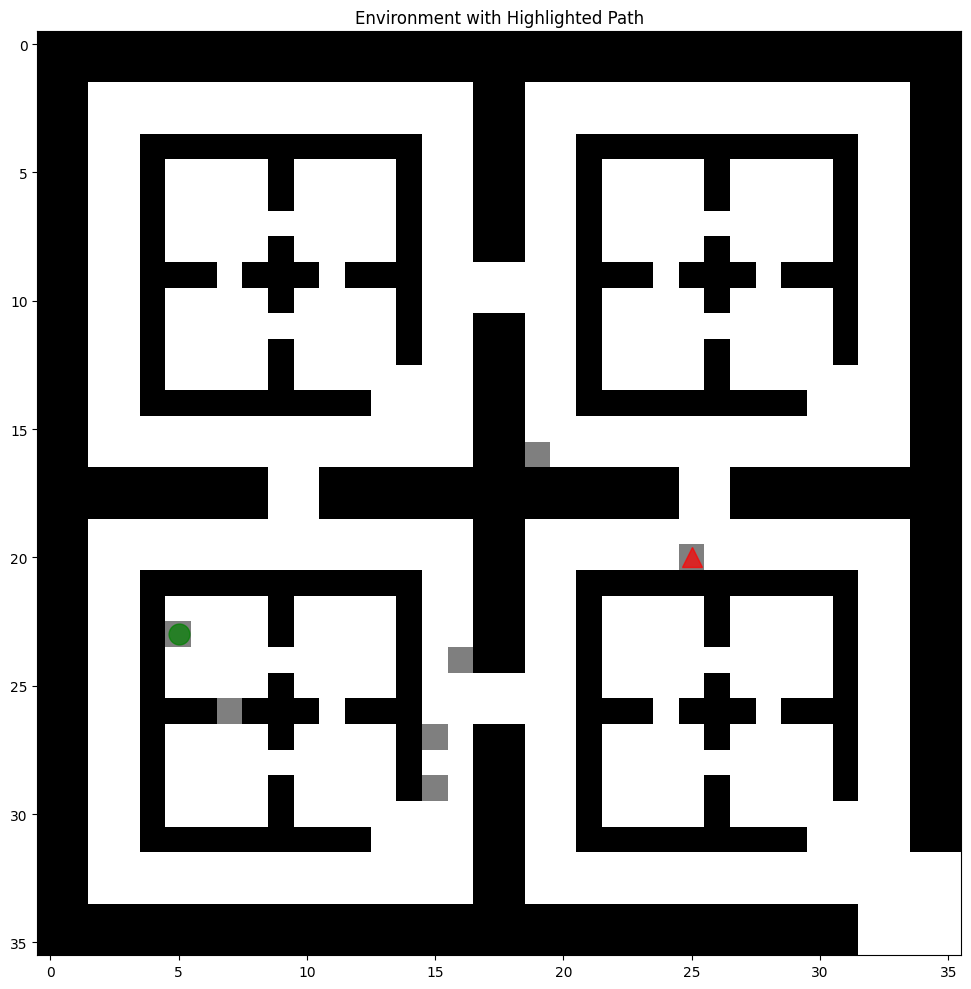

Node 595: 7 times
Node 745: 16 times
Node 833: 27 times
Node 880: 5 times
Node 943: 28 times
Node 987: 8 times
Node 1059: 9 times


In [110]:
a = 3 # action (stay)
c = float(manifold.c.value) # manifold curvature
g_manifold = geoopt.PoincareBall(c=c)
# manifold is defined at this point in the code
with torch.no_grad():
    action_name = env.action_map[a]
    nodes = torch.tensor(env.get_unflattened_valid_indices())[:, None]
    # print(nodes)
    # nodes = torch.arange(env.num_nodes)[:, None]
    actions = torch.cat([nodes, torch.full(nodes.shape, a)], dim=-1)
    latents = encoder1(actions)
    latents_tensor = latents
    if hyperbolic:
        latents = latents.tensor
    
    # print(latents.shape)
    
    # Choose two random points for geodesic path
    idx1, idx2 = torch.randint(0, len(nodes), (2,))
    
    p1 = latents[idx1]
    p2 = latents[idx2]
    
    g_p1 = tuple(float(x) for x in latents[idx1])
    g_p2 = tuple(float(x) for x in latents[idx2])
    
    # Compute geodesic path
    num_points = 100
    t_values = torch.linspace(0, 1, num_points)
    geodesic_points = g_manifold.geodesic(t_values.unsqueeze(-1), p1.unsqueeze(0), p2.unsqueeze(0))
    
    # Find nearest neighbors for each point on the geodesic path
    nearest_neighbors = []
    for point in geodesic_points:
        x = ManifoldTensor(point.unsqueeze(0), manifold=manifold)
        
        # Ensure x and latents_tensor have compatible shapes for cdist
        if x.dim() == 2 and latents_tensor.dim() == 2:
            distances = manifold.dist(x, latents_tensor)
        elif x.dim() == 2 and latents_tensor.dim() == 3:
            distances = manifold.dist(x, latents_tensor.squeeze(1))
        else:
            raise ValueError(f"Incompatible shapes: x: {x.shape}, latents: {latents_tensor.shape}")
        
        nearest_neighbor_idx = distances.argmin().item()
        nearest_neighbors.append(nodes[nearest_neighbor_idx])
    
    # Convert to tensor for easier manipulation
    nearest_neighbors = torch.tensor(nearest_neighbors)
    
    # Count occurrences of each nearest neighbor
    unique_neighbors, counts = torch.unique(nearest_neighbors, return_counts=True)
    
    print("Geodesic path from node", idx1.item(), "to node", idx2.item())
    print("Nearest neighbors along the path:")
    
    start = nodes[idx1]
    end = nodes[idx2]
    path = [start] + list(unique_neighbors) + [end]
    path = [int(x) for x in path]
    print(path)
    
    # Plot the latents with geodesic path and nearest neighbors
    if config['embedding_dim'] == 1:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    else:
        fig, ax2 = plt.subplots(1, 1, figsize=(20, 10))
    
#     # Plot latents and geodesic path
#     if config['embedding_dim'] == 2:
#         plot_latents(ax1, 
#                      latents, 
#                      title=f"$\psi$(State, Action: {action_name})", 
#                      g_points=(g_p1, g_p2),
#                      c=c)

#         # Outline the nearest neighbors with red
#         path_coords = latents[path]
#         ax1.scatter(path_coords[:, 0], path_coords[:, 1], 
#                     facecolors='none', edgecolors='blue', 
#                     s=100, linewidths=4, zorder=5)

    # Plot the environment with highlighted path
    env.display(highlight_path=path, ax=ax2, start=int(start), end=int(end), display_agent=False)
    ax2.set_title("Environment with Highlighted Path")
    
    plt.tight_layout()
    plt.show()

# Display the nearest neighbors information
for neighbor, count in zip(unique_neighbors, counts):
    print(f"Node {neighbor.item()}: {count.item()} times")

In [ ]:
unique_neighbors

In [ ]:
import networkx as nx
